In [104]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

import json 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium # map rendering library

# !pip install lxml
# !pip install html5lib 
import lxml
import html5lib

print('Libraries imported.')

Libraries imported.


## Scraping the list of cities in Los Angeles

In [105]:
tables = pd.read_html("https://en.wikipedia.org/wiki/List_of_cities_in_Los_Angeles_County,_California")

In [106]:
tables[0].head()

,0,1,2
0,City,Date incorporated,Population as of(2010 Census)
1,Agoura Hills,"December 8, 1982",20330
2,Alhambra,"July 11, 1903",83653
3,Arcadia,"August 5, 1903",56364
4,Artesia,"May 29, 1959",16522


In [107]:
tables[0].iloc[0,].tolist()

[u'City', u'Date incorporated', u'Population as of(2010 Census)']

In [108]:
df = tables[0].iloc[1:,]
df.columns = tables[0].iloc[0,].tolist()
df.head()

,City,Date incorporated,Population as of(2010 Census)
1,Agoura Hills,"December 8, 1982",20330
2,Alhambra,"July 11, 1903",83653
3,Arcadia,"August 5, 1903",56364
4,Artesia,"May 29, 1959",16522
5,Avalon,"June 26, 1913",3728


## Geocoder

In [109]:
geo = pd.DataFrame()
geo['city'] = df['City']
geo['lat'] = np.nan
geo['lng'] = np.nan
geo.head()

,city,lat,lng
1,Agoura Hills,NaN,NaN
2,Alhambra,NaN,NaN
3,Arcadia,NaN,NaN
4,Artesia,NaN,NaN
5,Avalon,NaN,NaN


## Foursquare Credentials and Version

In [110]:
CLIENT_ID     = 'V5HIEEHHSIYDH0BFNYFMVW3VZIZOKD0RYUTHA20ZXINBGY1Q' # your Foursquare ID
CLIENT_SECRET = 'GRBWR0TMP1N2PUNOGE4SGBMNSK14D0W0ZQ2HBUA5IGYBDAQW' # your Foursquare Secret
VERSION = '20190721'
LIMIT = 30

## Iteratively geocoding postal codes

In [111]:
df_tmp = geo.iloc[:,]
print(df_tmp.shape)

(88, 3)


In [112]:
for i in range(len(df_tmp)):
    adr = df_tmp.iloc[i,0] +' , California, United States'
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(adr)
    
    df_tmp.iloc[i,1] = float(location.latitude)
    df_tmp.iloc[i,2] = float(location.longitude)
#     print("Done " + df_tmp.iloc[i, 0])

print(len(df_tmp))

88


In [113]:
df_tmp.head()

,city,lat,lng
1,Agoura Hills,34.136395,-118.774535
2,Alhambra,34.093042,-118.127060
3,Arcadia,34.136207,-118.040150
4,Artesia,33.869020,-118.079620
5,Avalon,33.342210,-118.327261


## add markers to map

In [114]:
df_w = df_tmp

In [115]:
map_ = folium.Map(location=[34.0522, -118.2437], zoom_start=9)

# add markers to map
for lat, lng, label in zip(df_w['lat'], df_w['lng'], df_w['city']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_)  
    
map_

## Function to get all nearby venues

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=600):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
LIMIT = 30
radius = 600
wawa_venues = getNearbyVenues(names=df_w['city'],
                                   latitudes=df_w['lat'],
                                   longitudes=df_w['lng']
                                  )

Agoura Hills
Alhambra
Arcadia
Artesia
Avalon
Azusa
Baldwin Park
Bell
Bell Gardens
Bellflower
Beverly Hills
Bradbury
Burbank
Calabasas
Carson
Cerritos
Claremont
Commerce
Compton
Covina
Cudahy
Culver City
Diamond Bar
Downey
Duarte
El Monte
El Segundo
Gardena
Glendale
Glendora
Hawaiian Gardens
Hawthorne
Hermosa Beach
Hidden Hills
Huntington Park
Industry
Inglewood
Irwindale
La Cañada Flintridge
La Habra Heights
La Mirada
La Puente
La Verne
Lakewood
Lancaster
Lawndale
Lomita
Long Beach
Los Angeles
Lynwood
Malibu
Manhattan Beach
Maywood
Monrovia
Montebello
Monterey Park
Norwalk
Palmdale
Palos Verdes Estates
Paramount
Pasadena
Pico Rivera
Pomona
Rancho Palos Verdes
Redondo Beach
Rolling Hills
Rolling Hills Estates
Rosemead
San Dimas
San Fernando
San Gabriel
San Marino
Santa Clarita
Santa Fe Springs
Santa Monica
Sierra Madre
Signal Hill
South El Monte
South Gate
South Pasadena
Temple City
Torrance
Vernon
Walnut
West Covina
West Hollywood
Westlake Village
Whittier


In [30]:
print(wawa_venues.shape)
wawa_venues.head(-20)

(1742, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agoura Hills,34.136395,-118.774535,A Fast Electrician Agoura Hills,34.136442,-118.774670,Home Service
1,Agoura Hills,34.136395,-118.774535,Key Service Agoura Hills,34.136378,-118.773805,Locksmith
2,Agoura Hills,34.136395,-118.774535,Charm Thai Cuisine,34.136797,-118.774384,Thai Restaurant
3,Alhambra,34.093042,-118.127060,Borneo Kalimantan Cuisine,34.094818,-118.126659,Food
4,Alhambra,34.093042,-118.127060,Blaze Pizza,34.095420,-118.125894,Pizza Place
5,Alhambra,34.093042,-118.127060,Grill 'Em All,34.095595,-118.126725,Burger Joint
6,Alhambra,34.093042,-118.127060,Sprouts Farmers Market,34.095494,-118.125229,Grocery Store
7,Alhambra,34.093042,-118.127060,85C Bakery Cafe,34.093411,-118.130214,Bakery
8,Alhambra,34.093042,-118.127060,Charlie's Trio Cafe,34.094834,-118.127887,Italian Restaurant
9,Alhambra,34.093042,-118.127060,Havana House Cigars & Lounge,34.094434,-118.128742,Lounge


In [31]:
print('There are {} uniques categories.'.format(len(wawa_venues['Venue Category'].unique())))

There are 253 uniques categories.


In [32]:
wawa_onehot = pd.get_dummies(wawa_venues[['Venue Category']], 
                             prefix="", prefix_sep="")

# len(list(filter(lambda x: 'Nei' not in x, wawa_onehot.columns)))
# 249

wawa_onehot = wawa_onehot[list(filter(lambda x: 'Neighborhood' not in x, wawa_onehot.columns))]
wawa_onehot['Neighborhood'] = wawa_venues['Neighborhood'] 
# neighborhood column to the first column
fixed_columns = [wawa_onehot.columns[-1]] + list(wawa_onehot.columns[:-1])
wawa_onehot = wawa_onehot[fixed_columns]

print(wawa_onehot.shape)
wawa_onehot.head()

(1742, 254)


,Neighborhood,ATM,Accessories Store,African Restaurant,Airport,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Beach,Beer Garden,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Business Center,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Church,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dive Spot,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,Event Space,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Lawyer,Library,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Night Market,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outlet Mall,Outlet Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pop-Up Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,Stationery Store,Steakhouse,Storage Facility,Summer Camp,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trade School,Trail,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Yoga Studio
0,Agoura Hills,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [33]:
wawa_grouped = wawa_onehot.groupby('Neighborhood').mean().reset_index()
wawa_grouped.head(10)

,Neighborhood,ATM,Accessories Store,African Restaurant,Airport,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Beach,Beer Garden,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Business Center,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Church,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dive Spot,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,Event Space,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Lawyer,Library,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Night Market,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outlet Mall,Outlet Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pop-Up Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,Stationery Store,Steakhouse,Storage Facility,Summer Camp,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trade School,Trail,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Yoga Studio
0,Agoura Hills,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.

In [34]:
print(df_w.shape)
wawa_grouped.shape

(88, 3)


(87, 254)

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

        
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = wawa_grouped['Neighborhood']

for ind in np.arange(wawa_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(wawa_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agoura Hills,Locksmith,Thai Restaurant,Home Service,Yoga Studio,Financial or Legal Service,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
1,Alhambra,Bakery,Café,Seafood Restaurant,Burger Joint,Thai Restaurant,Gastropub,Sushi Restaurant,Bookstore,Lounge,Market
2,Arcadia,Food Truck,Optical Shop,Racetrack,Athletics & Sports,Restaurant,Fountain,American Restaurant,Track,Park,Night Market
3,Artesia,Indian Restaurant,Chinese Restaurant,Sandwich Place,Bubble Tea Shop,Thai Restaurant,Hotel,Salon / Barbershop,Filipino Restaurant,Bank,Dessert Shop
4,Avalon,Hotel,Seafood Restaurant,Mexican Restaurant,Pizza Place,ATM,Café,Boat or Ferry,Brewery,Burger Joint,Candy Store
5,Azusa,Mexican Restaurant,Pizza Place,Liquor Store,Big Box Store,Coffee Shop,Bank,Burger Joint,Bakery,Mobile Phone Shop,Mediterranean Restaurant
6,Baldwin Park,Mexican Restaurant,Discount Store,Burger Joint,Bank,Pharmacy,Pizza Place,Asian Restaurant,Fast Food Restaurant,Buffet,Men's Store
7,Bell,Mexican Restaurant,Pizza Place,ATM,Diner,Burger Joint,Chinese Restaurant,Shoe Store,Sandwich Place,Coffee Shop,Convenience Store
8,Bell Gardens,Mexican Restaurant,Burger Joint,Park,Sporting Goods Shop,Fried Chicken Joint,New American Restaurant,Fast Food Restaurant,Liquor Store,Coffee Shop,Grocery Store
9,Bellflower,Trail,Sandwich Place,Concert Hall,Yoga Studio,Filipino Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service


In [37]:
df_w.head()

,city,lat,lng
1,Agoura Hills,34.136395,-118.774535
2,Alhambra,34.093042,-118.127060
3,Arcadia,34.136207,-118.040150
4,Artesia,33.869020,-118.079620
5,Avalon,33.342210,-118.327261


## Clustering cities

In [59]:
# set number of clusters
kclusters = 10

wawa_grouped_clustering = wawa_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(wawa_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:40]

array([7, 6, 6, 6, 6, 1, 1, 1, 1, 1, 6, 2, 1, 0, 1, 0, 6, 6, 1, 6, 1, 6, 1,
       6, 1, 1, 6, 6, 8, 6, 1, 1, 6, 3, 1, 6, 6, 1, 6, 0], dtype=int32)

In [63]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_, )
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,7,Agoura Hills,Locksmith,Thai Restaurant,Home Service,Yoga Studio,Financial or Legal Service,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
1,6,Alhambra,Bakery,Café,Seafood Restaurant,Burger Joint,Thai Restaurant,Gastropub,Sushi Restaurant,Bookstore,Lounge,Market
2,6,Arcadia,Food Truck,Optical Shop,Racetrack,Athletics & Sports,Restaurant,Fountain,American Restaurant,Track,Park,Night Market
3,6,Artesia,Indian Restaurant,Chinese Restaurant,Sandwich Place,Bubble Tea Shop,Thai Restaurant,Hotel,Salon / Barbershop,Filipino Restaurant,Bank,Dessert Shop
4,6,Avalon,Hotel,Seafood Restaurant,Mexican Restaurant,Pizza Place,ATM,Café,Boat or Ferry,Brewery,Burger Joint,Candy Store


In [68]:
wawa_merged = df_w
wawa_merged.columns = ['Neighborhood','lat','lng']
wawa_merged.head()

,Neighborhood,lat,lng
1,Agoura Hills,34.136395,-118.774535
2,Alhambra,34.093042,-118.127060
3,Arcadia,34.136207,-118.040150
4,Artesia,33.869020,-118.079620
5,Avalon,33.342210,-118.327261


In [69]:
wawa_merged = wawa_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [75]:
wawa_merged.head()

,Neighborhood,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Agoura Hills,34.136395,-118.774535,7.0,Locksmith,Thai Restaurant,Home Service,Yoga Studio,Financial or Legal Service,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
2,Alhambra,34.093042,-118.127060,6.0,Bakery,Café,Seafood Restaurant,Burger Joint,Thai Restaurant,Gastropub,Sushi Restaurant,Bookstore,Lounge,Market
3,Arcadia,34.136207,-118.040150,6.0,Food Truck,Optical Shop,Racetrack,Athletics & Sports,Restaurant,Fountain,American Restaurant,Track,Park,Night Market
4,Artesia,33.869020,-118.079620,6.0,Indian Restaurant,Chinese Restaurant,Sandwich Place,Bubble Tea Shop,Thai Restaurant,Hotel,Salon / Barbershop,Filipino Restaurant,Bank,Dessert Shop
5,Avalon,33.342210,-118.327261,6.0,Hotel,Seafood Restaurant,Mexican Restaurant,Pizza Place,ATM,Café,Boat or Ferry,Brewery,Burger Joint,Candy Store


## Map with clusters

In [100]:
# create map
map_clusters = folium.Map(location=[34.0522, -118.2437], zoom_start=10)

#  colors for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(wawa_merged['lat'], wawa_merged['lng'], wawa_merged['Neighborhood'], wawa_merged['Cluster Labels']):
    cluster = int(cluster)
    label = folium.Popup(poi, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Profiling cluster with 1st most common venue

In [78]:
def most_common(clus):
    c_ = wawa_merged.loc[wawa_merged['Cluster Labels'] == int(clus), wawa_merged.columns[[0]].tolist() + wawa_merged.columns[3:].tolist()] 
    return(pd.DataFrame(c_['1st Most Common Venue'].value_counts(normalize=True)).head())

In [79]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

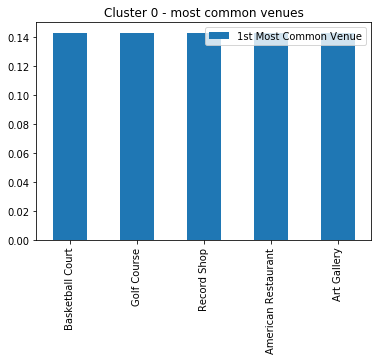

,1st Most Common Venue
Basketball Court,0.142857
Golf Course,0.142857
Record Shop,0.142857
American Restaurant,0.142857
Art Gallery,0.142857


In [80]:
cluster=0

most_common(cluster).plot.bar()
plt.title('Cluster 0 - most common venues') 
plt.show()

most_common(cluster)

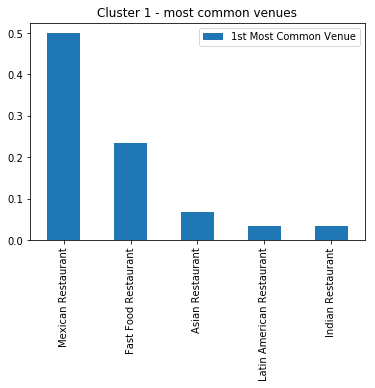

,1st Most Common Venue
Mexican Restaurant,0.500000
Fast Food Restaurant,0.233333
Asian Restaurant,0.066667
Latin American Restaurant,0.033333
Indian Restaurant,0.033333


In [81]:
cluster=1

most_common(cluster).plot.bar()
plt.title('Cluster 1 - most common venues') 
plt.show()

most_common(cluster)

In [88]:
cluster=2
most_common(cluster)

,1st Most Common Venue
Trail,1.0


In [89]:
cluster=3
most_common(cluster)

,1st Most Common Venue
Concert Hall,1.0


In [90]:
cluster=4
most_common(cluster)

,1st Most Common Venue
Park,1.0


In [91]:
cluster=5
most_common(cluster)

,1st Most Common Venue
IT Services,1.0


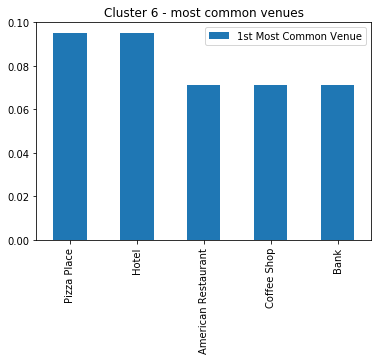

,1st Most Common Venue
Pizza Place,0.095238
Hotel,0.095238
American Restaurant,0.071429
Coffee Shop,0.071429
Bank,0.071429


In [93]:
cluster=6

most_common(cluster).plot.bar()
plt.title('Cluster 6 - most common venues') 
plt.show()

most_common(cluster)

In [95]:
cluster=7

most_common(cluster)

,1st Most Common Venue
Locksmith,1.0


In [96]:
cluster=8
most_common(cluster)

,1st Most Common Venue
Trail,1.0


In [97]:
cluster=9
most_common(cluster)

,1st Most Common Venue
Gym / Fitness Center,1.0


## Results - findings about clusters:

* Cluster 0 - There are a lot of people. It is good for American food.
* Cluster 1 - Good place for restaurant. Top 3 are Mexican food, fast food and Asian food.
* Cluster 6 - Hotel zone. Good for fast food, like pizza and cafe, or American food.
* The rest clusters are not good for restaurants at all.